In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

In [2]:
# Data Loading
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    !wget https://github.com/AkeemSemper/ML_for_Non_DS_Students/raw/main/data/phone_train.csv
    !wget https://github.com/AkeemSemper/ML_for_Non_DS_Students/raw/main/data/mtcars.csv
    df = pd.read_csv("phone_train.csv")
    df_reg = pd.read_csv("mtcars.csv")
else:
    df = pd.read_csv("../data/phone_train.csv")
    df_reg = pd.read_csv("../data/mtcars.csv")
    
df_reg.drop(columns={"model"}, inplace=True)

# Feature Selection

To this point we've looked at a few things that we can do to "tune" our models, or make them more accurate, such as:
<ul>
<li> Grid search to test different hyperparameters. 
<li> Regularization. 
<li> Bagging ensembles with bootstrapping. 
<li> Basis functions to allow more degrees of freedom for our models to fit data. 
<li> Pruning tree based models. 
<li> Early stopping - stopping training when accuracy is best. (We'll look at this more later)
</ul>

These tuning techniques all focused on what happens to the model, or what the model is allowed to do, as it is training. We can add to this by focusing on improving models by carefully choosing which pieces of data to use in the feature set, or feature selection. 

## Feature Selection Basics

Feature selection is the process of choosing which features to include in the model. The premise is that by removing irrelevant or redundant features, we can improve the model's performance.

One important thing to note is that by removing features we usually won't see a massive increase in accuracy. However, we can see a decrease in training time, and a decrease in overfitting. It is possible that a model with less useful features removed will perform better than a model with all features included, but this is not always the case. In general, having a smaller feature set is better - it allows for models that are less prone to overfit, quicker to train and run, easier to interpret, and easier to manage data for. If we can trim a model down to only requiring a small subset of critical features, while not losing much accuracy, that model is generally more useful.

### Load Some Data

We can look at some feature selection techniques to try to determine which of these features is important and which are more noise. 

#### Classification Data

This data is on cell phones, the target is the varaible "price_range" - a multi-way classification. 

In [3]:

df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


In [5]:
y = df["price_range"]
X = df.drop(columns={"price_range"})

#### Regression Data

This data is on cars, the target is the variable "mpg" - a regression problem.

In [6]:
#Load some regression data
df_reg.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [7]:
yreg = df_reg["mpg"]
Xreg = df_reg.drop(columns={"mpg"})

## Insepection

The first and most important method of feature selection is something that we started looking at in Stats, examining the data to see if there are any obvious problems. 

We can look for things like:
<ul>
<li> Features that don't vary much - if a value is always the same, that isn't helpful in making predictions. 
<li> Features that are not useful from a domain knowledge persepective - if we understand the problem we are attempting to solve, we can sometimes see that a feature is not useful.
<li> Features that are highly correlated with other features or  multicolinierity - if two features are highly correlated, we can often drop one of them. 
</ul>

This manual first pass may be substantial, especially if we are dealing with data "from the wild" that is likely to be messy. For data that is more structured, it is less likely that we will need to do much here. For data that is largely numerical, the pairplot is likely a good way to get a quick overall look at the data, and idetnify any places where we may want to look more closely. For categorical data, we can look at the counts of each category, and the distribution of the target variable for each category with something like a countplot. The tool choice here is largely a matter of taste and the data at hand.

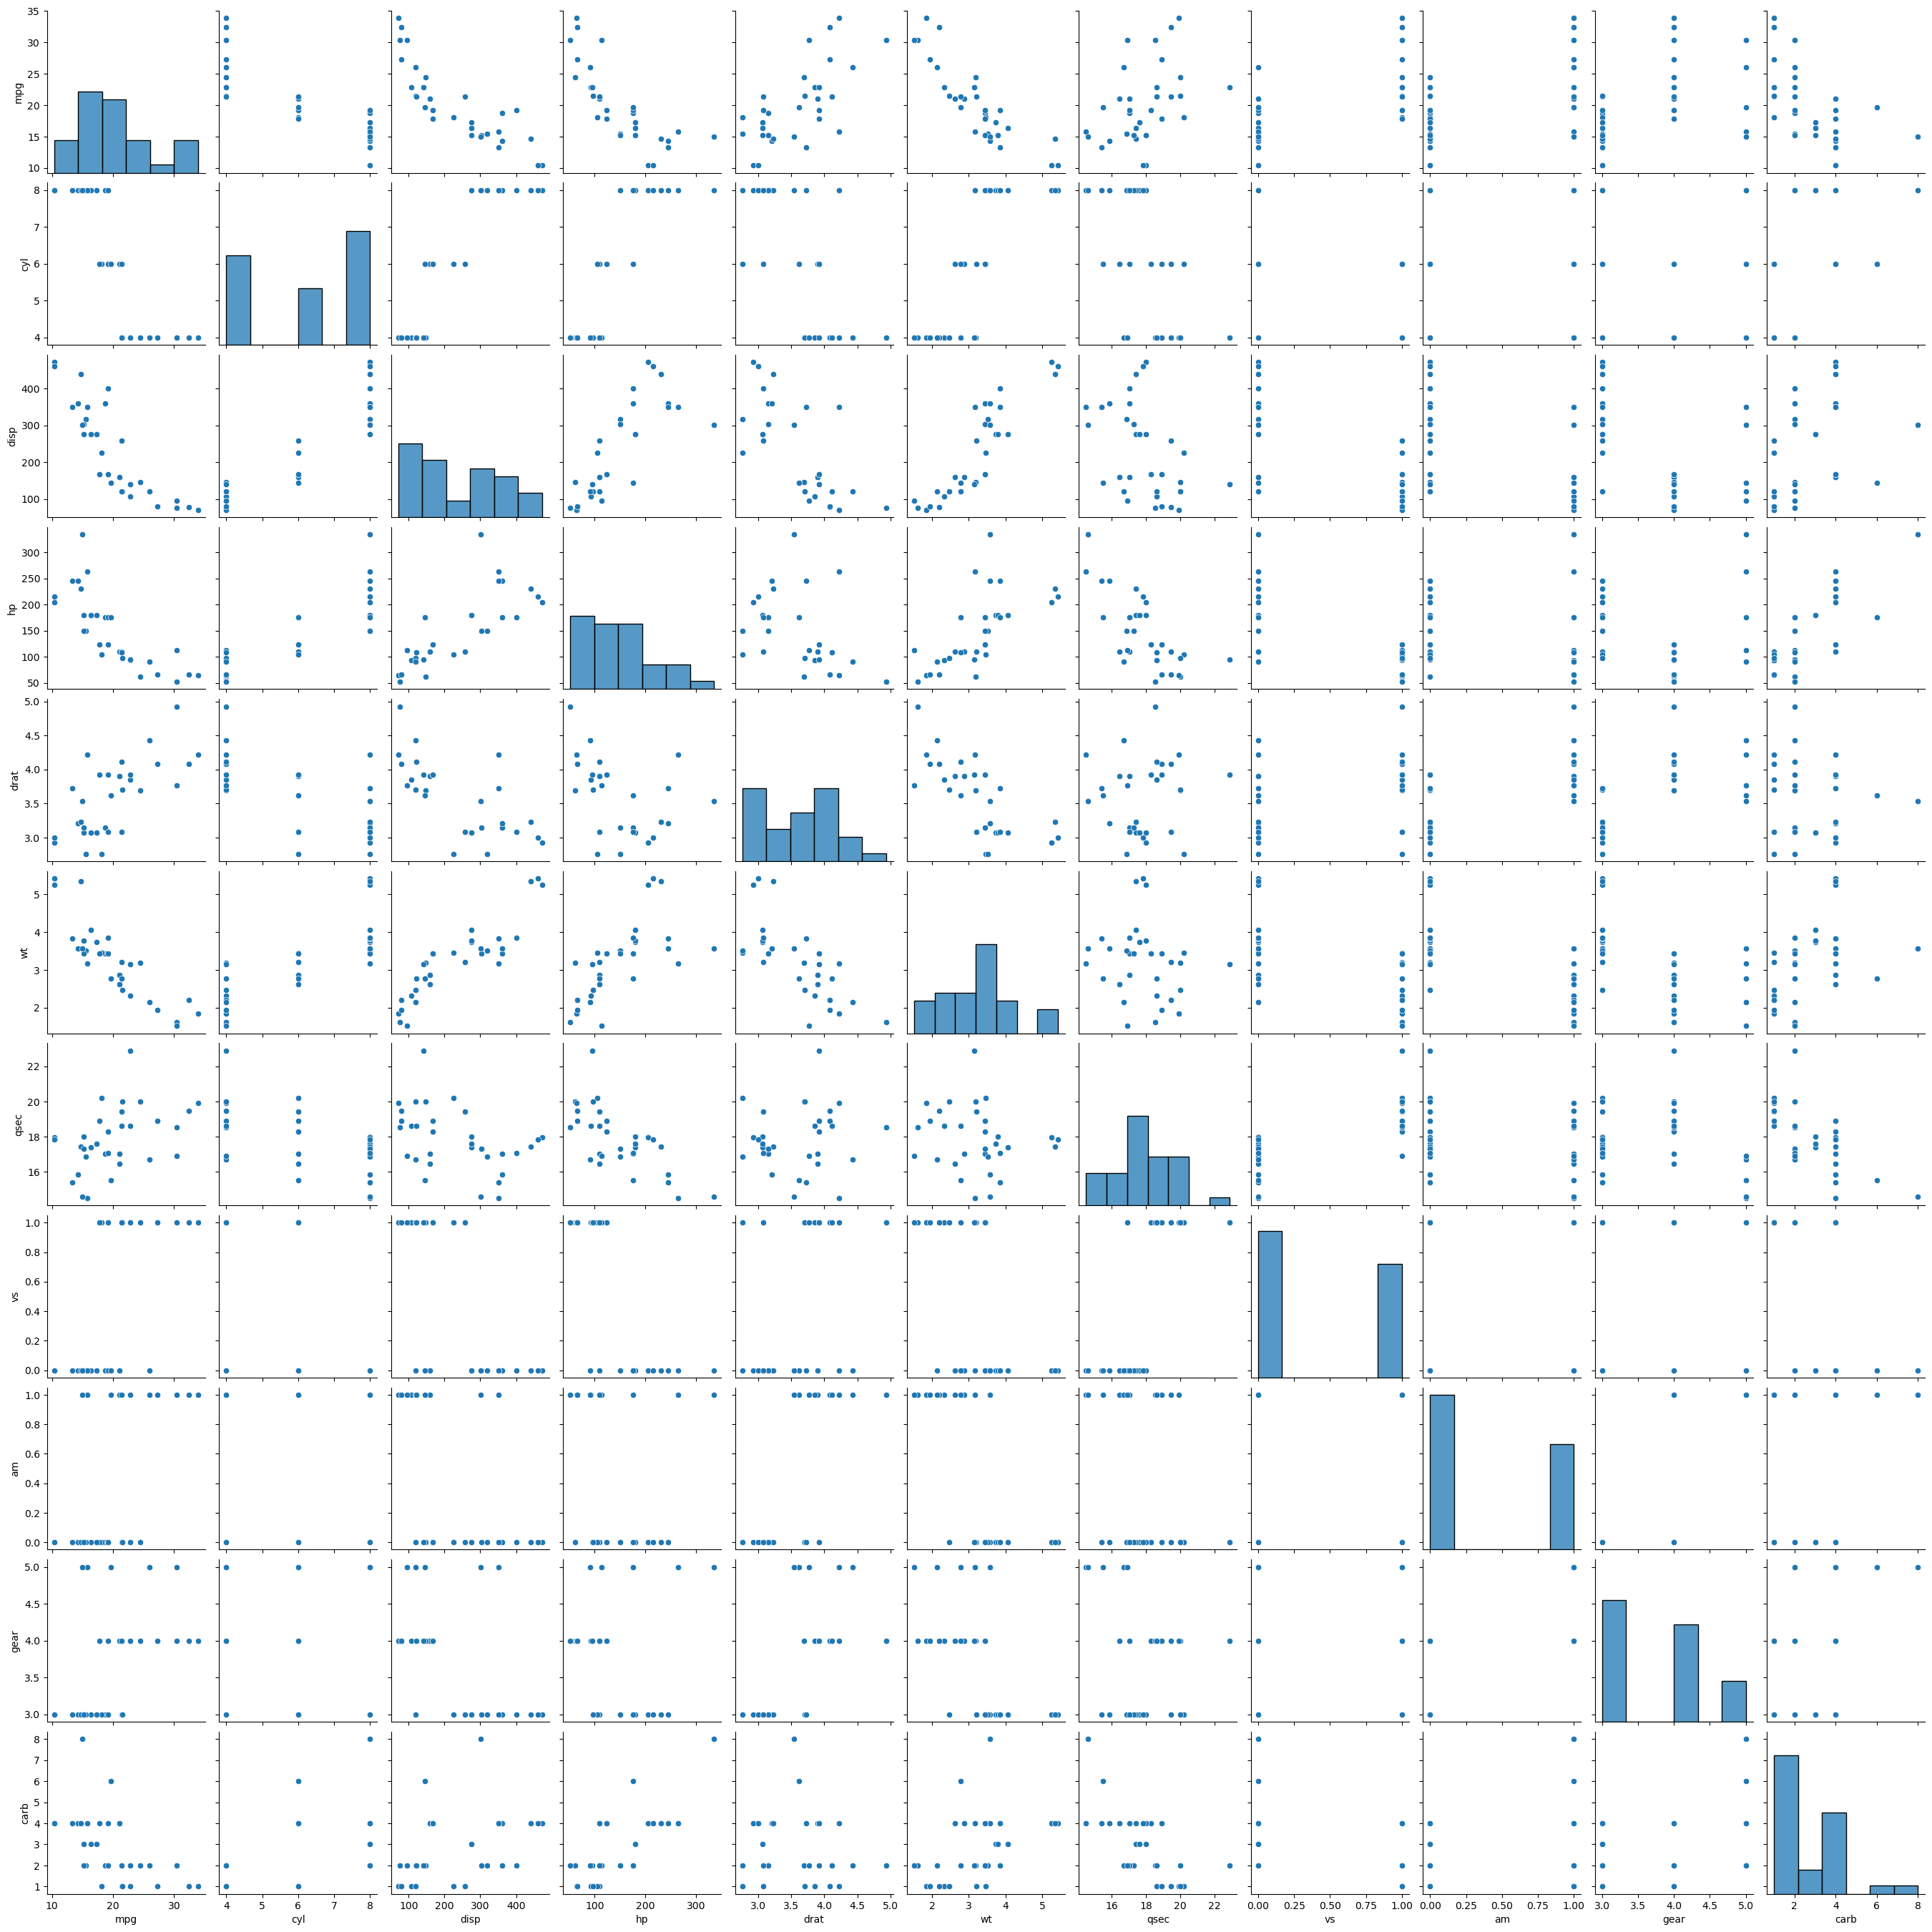

In [8]:
sns.pairplot(df_reg)

## Variance Threshold

One of the most simple screens we can do for the usefullness of a feature is to look at its varaiance. If we have features that are always the same/almost the same value, that's not really very useful in making predictions. By default the variance threshold removes anything with 0 variance, we can provide an argument when creating the function to raise that threshold. 

The variance threshold is especially usefull where we have a large number of features, where some of them are almost always the same value. E.g. in the US some colleges offer a tuition discount for children of employees. If there was a feature like "employee_discount_rate" a few students would have a value, but almost everyone would be 0. This would filter that out. 

This variance based selection is the equivalent of looking at distributions of the features, and filtering out those that don't vary much, or have almost the same value for all observations.

In [9]:
from sklearn.feature_selection import VarianceThreshold
var_th = VarianceThreshold(.2)
print(X.shape)
post_vt = var_th.fit_transform(X)
print(post_vt.shape)

mask = var_th.get_support()
new_features = X.columns[mask]
print(new_features)

(2000, 20)
(2000, 18)
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width',
       'ram', 'sc_h', 'sc_w', 'talk_time', 'touch_screen', 'wifi'],
      dtype='object')


# of Removed Features:  2
m_dep three_g


<Axes: ylabel='Density'>

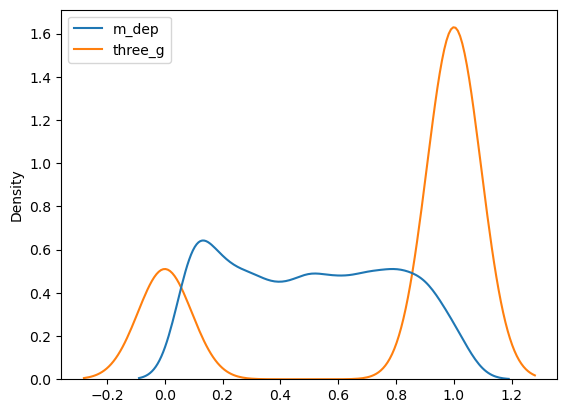

In [10]:
removed_features = X.columns[~mask]
print("# of Removed Features: ", len(removed_features))
print(*removed_features)
sns.kdeplot(data=X[removed_features])

## Univariate Selection 

Univariate selection looks at one feature at a time, and evaluates its connection with the target, we can directly utilize some stats skillz to do some feature selection. If a feature is more correlated with a target, it does a better job of acting as a predictor. This process of feature selection builds on the same concepts. We can use this in combination with some sklearn functions to evaluate that relationship between targets and features. In sklearn the two features SelectKBest and SelectPercentile can be used to select the best K features or the best percentile of features. 

The best can be evaluated in different ways depending on if we are doing a regression or classification:
<ul>
<li><b>Regression:</b> f_regression (correlation), mutual_info_regression (mutual info).
<li><b>Classification:</b> f_classif (ANOVA), chi2 (~correlation), mutual_info_classif (mutual info)
</ul>

So the feature selection process will select the features that are most "connected" with the target value, where that connection is defined either by some measure of correlation or some measure of mutual information. In plain English, we keep the features that individually tell us the most about the target. This "tell us the most about" bit can be measured in different ways, depending on the details of the data, but the idea is some variation of correlation with the target. 

### Mutual Information

Mutual information feature selection is based on information gain, the same idea that we used to create a tree. Like a tree, this selects variable based on which ones do a better job of increasing the information gain. 

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

# K best - broken out
kb = SelectKBest(chi2, k=15)
kb2 = kb.fit(X,y)
post_c2 = kb2.transform(X)
print("K-Best:", post_c2.shape)

#Print the features
mask = kb2.get_support()
new_features = X.columns[mask]
print("K-Best Features:", new_features)


# Percentile - condensed
post_per = SelectPercentile(chi2, percentile=60).fit_transform(X,y)
print("Percentile:", post_per.shape)

#Mutual Info
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X,y.ravel())
print("Mutual Info:", post_mut_inf.shape)

K-Best: (2000, 15)
K-Best Features: Index(['battery_power', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt',
       'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w',
       'talk_time', 'touch_screen'],
      dtype='object')
Percentile: (2000, 12)
Mutual Info: (2000, 10)


## Internal Selection (Embedded)

Some algorithms give us 'automatic' feature selection as they create their model, as part of the training process. Some examples are:
<ul>
<li>Trees
<li>Lasso Regression
</ul>

We can extract the feature selection results and use that to inform us of which features to keep or remove. 

### Lasso Regression

Lasso regression is a type of regression that uses L1 regularization. This means that it adds a penalty to the size of the coefficients, and can drive some of them to 0. This is a form of feature selection, as it will remove some of the features from the model. This works in a very similar way to the CCP alpha regularization we saw in trees. Here, there is a penalty added to the cost function that is based on the size of the coefficients, so the model is encouraged to bot be as accurate as possible (the cost) as well as have as small of coefficients as possible (the penalty). Like with a tree, this is a way that the model can combat overfitting dynamically, as it is training.

<Axes: >

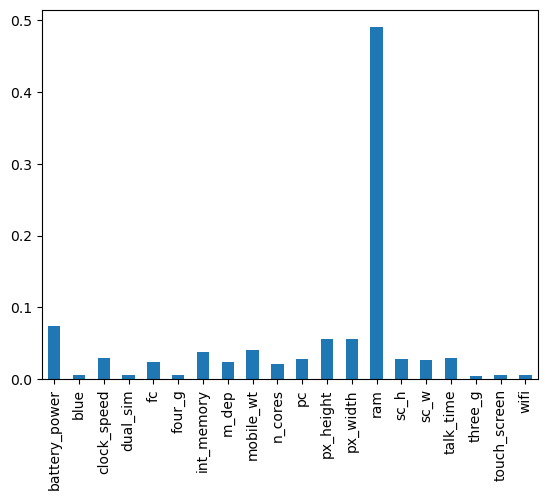

In [12]:
#Forest Example
randFor = RandomForestClassifier()

randFor.fit(X,y)
feat_names = X.columns
for_imp = randFor.feature_importances_
forest_imp = pd.Series(for_imp, index=feat_names)
forest_imp.plot.bar()

In [13]:
#Lasso
lasso = Lasso()
x_reg_dum = pd.get_dummies(Xreg, drop_first=True)
lasso.fit(x_reg_dum, yreg)
coeff = lasso.coef_
print("Zero'd:", np.array(x_reg_dum.columns)[coeff==0])
print("Kept:", np.array(x_reg_dum.columns)[coeff!=0])

Zero'd: ['cyl' 'drat' 'wt' 'qsec' 'vs' 'am' 'gear' 'carb']
Kept: ['disp' 'hp']


### Select from Model

We can use the feature selection aspect of models to do the same selection as above in a more direct way. The SelectFromModel function can be used to select features based on the importance of whatever model we pass in. The L1 Lasso regularization and the tree feature importance can both be used this way since they have the ability to determine the importance of their features. 

<b>Note:</b> The "mask" and get_support bit is a way to get the feature names out of the selection process. The mask is a boolean array that is true for the features that were selected, we then use that to pull out all the selected column names, and print them out. 

#### Lasso Based Selection

In [14]:
#Lasso based 
from sklearn.feature_selection import SelectFromModel
l1_selection = Lasso().fit(x_reg_dum, yreg)
sfm = SelectFromModel(l1_selection, prefit=True)
x_reg_new = sfm.transform(x_reg_dum)
print(x_reg_new.shape)

mask = sfm.get_support()
new_features = x_reg_dum.columns[mask]
print(new_features)

(32, 2)
Index(['disp', 'hp'], dtype='object')


/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


#### Tree Based Selection

In [15]:
#Tree Based
tree_sel = RandomForestClassifier().fit(X, y)
sfm_class = SelectFromModel(tree_sel, prefit=True)
x_new = sfm_class.transform(X)
print(x_new.shape)

mask = sfm_class.get_support()
new_features = X.columns[mask]
print(new_features)

(2000, 4)
Index(['battery_power', 'px_height', 'px_width', 'ram'], dtype='object')


/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Recursive Feature Elimination

<b>Note:</b> Recursion is a common programming concept that basically means to continue to repeat the same thing over and over on a smaller version of the same problem. 

Recursive feature elimination uses recursion to keep removing features, creating a smaller and smaller feature set. So we can basically cut a feature at a time out, create a model, and see how well we're doing. The ranking that we print out assigns all the stuff we keep a 1, and a bigger number to other ones. The process of recursive feature elimination looks like this:

![Recursive Feature Elimination](../images/rfecv.png "Recursive Feature Elimination")

<b>Note:</b> There is also Sequental Feature Selection, which functions similarly, either removing or adding features one at a time. 

In [16]:
from sklearn.feature_selection import RFE
est = LogisticRegression(max_iter=10000, solver="saga")
rfe = RFE(estimator=est, n_features_to_select=12, step=1)
rfe.fit(X, y)
print(rfe.ranking_)
mask = rfe.get_support()
new_features = X.columns[mask]
print(new_features)

[8 1 1 1 2 1 4 1 5 1 3 7 9 6 1 1 1 1 1 1]
Index(['blue', 'clock_speed', 'dual_sim', 'four_g', 'm_dep', 'n_cores', 'sc_h',
       'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'],
      dtype='object')


We can also step this up and search for the optimal number of features. RFECV will do a cross-validation and give us a breakdown of our accuracy with different numbers of features included. We can see the optimal number, as well as the relative scores for each number of features. 

Optimal number of features : 20
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


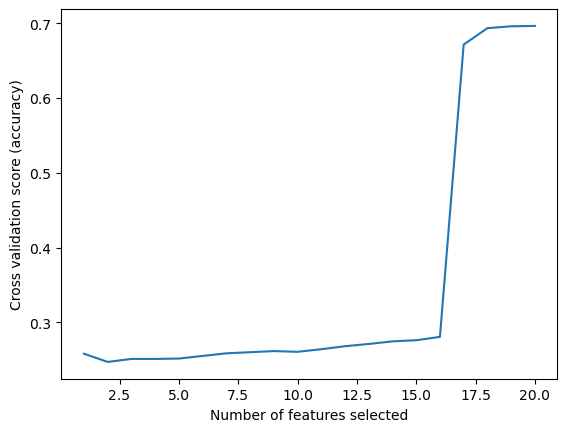

In [17]:
from sklearn.feature_selection import RFECV
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=est,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
mask = rfecv.get_support()
new_features = X.columns[mask]
print(new_features)

# Plot number of features VS. cross-validation scores
plt.figure()

plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
)
plt.show()

### Feature Selection in Pipeline

We can stack this feature selection stuff into a pipeline. This will allow us to have the feature selection happen automatically before the model training. Like most other sklearn things, the feature selection functionality fits well into the pipleline processes, so we can arrange it in as one of our step like we would preparation step such as scaling or imputation. 

Here we are using two separate models - a tree based forest for the feature importance bit, and a logistic regression for the actual predictions. We can use use any other models for the prediction bit, even if they don't have a feature importance function.

In [18]:
#Add a pipeline
model = RandomForestClassifier(n_jobs=-1)
pipe_model = LogisticRegression(max_iter=10000, solver="saga")

min_features_to_select = 1  # Minimum number of features to consider
rfecv_pipe = RFECV(
    estimator=pipe_model,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y)


pipeline_steps = [("fs", rfecv_pipe),
                ('model', model) ]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train_, y_train_)
print("Best Score:", pipe.score(X_test_, y_test_))
print("Best Number of Features:", rfecv_pipe.n_features_)
print("Best Features:", X.columns[rfecv_pipe.get_support()])

Best Score: 0.854
Best Number of Features: 19
Best Features: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'ram',
       'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'],
      dtype='object')


### With a Larger Grid Search

We can integrate the look for the best number of features into a larger grid search. This will allow us to look for the best number of features, as well as the best hyperparameters for the model. It is possible that the number of features and the capacity of a model can impact each other, so it is conceivable that we'll get different answers here. 

Be aware that this example has two grid searches, one for the number of features, and one for the hyperparameters. This can be computationally expensive. We can also use the RFECV to get the best number of features, and then do a grid search on the hyperparameters - in larger scenarios, this is probably a more practical approach.

In [19]:

pipe_grid_params = {
    'fs__min_features_to_select': [12, 15, 17],
    'model__max_depth': [4,6,8],
}

grid = GridSearchCV(pipe, pipe_grid_params, cv=3, n_jobs=-1)
grid.fit(X_train_, y_train_)
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Params: {'fs__min_features_to_select': 15, 'model__max_depth': 8}
Best Score: 0.806


## Feature Selection Usage

Feature selection, in general, will not result in a massive improvement in the accuracy of our model unless the data that we are selecting out is truly "bad". So it is pretty likely that other techniques such as hyperparameter selection will be better at improving accuracy.

As well, some techniques that we looked at, and some we will soon, perform the same/similar work as feature selection. For example, regularization will remove/minimize features that are not important. Other techniques, such as PCA, will create new features that are a combination of the old ones. That said, feature selection is still a useful tool to have in your toolbox, and can be used in combination with other techniques. Most notably, we can remove features that are not significant in helping us make predictions or are not relevant to what we want to predict. Making models with smaller feature sets is, in and of itself, an improvement. We can also more closely tie features to outcomes if we have a smaller set of features, and there are times where this may be important, such as if we are trying to explain the model to a non-technical audience. 

On the whole, feature selection is something we need to know, but it is something that is only sometimes important in real applications. It isn't odd to do feature selection, but it also isn't odd to not do it. In the emerging development of larger and smarter predictive models, feature selection is less important and deep learning models can use millions or billions of features without issue. One thing we do need to note is that there is a balance between the number of features and the number of observations - if we have a lot of features and a small number of observations, we can run into issues with overfitting. These large deep learning models are trained with massive amounts of data, so the huge feature sets are manageable.

In most cases, we have a relatively small number of features that provide a lot of information, and then further ones are less significant but still useful:

![Feature Selection](../images/feat_imp.png "Feature Selection")

## Exercise - Feature Selection on Pixels

We can try to do some feature selection on the pixels of our number images. The pixels around the edges are pretty much white for every digit, so I suspect that those are somewhat less important than the middle pixels. Remember, each pixel is a feature. 

In [20]:
#Load mnist data
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
Xp, yp = mnist["data"], mnist["target"]
print(Xp.shape)
print(yp.shape)

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


### Images as Data

We can think of images as data, with the pixel values as the features. In this case, the images are 28x28 pixels, for a total of 784 features. This image is grayscale, or black and white, so there is only one "color" channel - meaning that the actual dimensions are 28x28x1. If this were a color image, the dimensions would be 28x28x3, with 3 color channels (RGB - red, green, blue).

The most simple way to deal with an image is to simply "flatten" it into a one-dimensional array, where each feature is one pixel, and the value of that pixel is a number representing how dark it is. This value is normally on a scale from 0 to 255, but when used in machine learning, it is common to scale these features down to a 0 to 1 scale.

![MINST 3 Array](../images/minst_3_array.pbm "MINST 3 Array")

#### Shaping and Displaying Images

We can reshape the images back to 28x28 and display them. Dealing with shapes of data can be annoying when new, but it is typically more simple than we may think. The operations of flattening and reshaping always follow the same pattern, so as long as we don't do anything "weird", we can flatten and restore images without issue.

The plt.imshow() function is one of the most simple tools we can use to display images. We just need to feed it an array of the image, in the correct shape, and it will display it for us. The cmap argument is used to set the color map, which is how the values of the pixels are translated into colors. For this one, I used "binary", which is a black and white color map that will make it look mostly like actual writing. The color map can be set to anything, sometimes it is useful to use a different color map to highlight different aspects of the data.

Below we can look at an image in its flattened array format, its reshaped format, and the actual image.

![RGB Image Array](../images/rgb_image_array.png "RGB Image Array")

##### 1D Array Format

<b>Note:</b> the line gets wrapped, so it doesn't display as one line. 

In [21]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

sample_img = Xp.loc[7].values
df_tmp = pd.DataFrame(sample_img.reshape(1,-1))
#sample_img
df_tmp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,43.0,105.0,255.0,253.0,253.0,253.0,253.0,253.0,174.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,139.0,224.0,226.0,252.0,253.0,252.0,252.0,252.0,252.0,252.0,252.0,158.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0,252.0,252.0,252.0,252.0,253.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,

##### Reshaped Format

<b>Note:</b> I put this into a dataframe to display, as the array format doesn't print a nice 2D grid as well. The data is the same. 

In [22]:
sample_img = sample_img.reshape(28,28)
df_tmp = pd.DataFrame(sample_img)
#sample_img
#remove pandas column display limit
df_tmp


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,43.0,105.0,255.0,253.0,253.0,253.0,253.0,253.0,174.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,139.0,224.0,226.0,252.0,253.0,252.0,252.0,252.0,252.0,252.0,252.0,158.0,14.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0,252.0,252.0,252.0,252.0,253.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,59.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0,252.0,252.0,230.0,132.0,133.0,132.0,132.0,189.0,252.0,252.0,252.0,252.0,59.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,29.0,29.0,24.0,0.0,0.0,0.0,0.0,14.0,226.0,252.0,252.0,172.0,7.0,0.0,0.0,0.0,0.0,0.0


##### Image Format

Finally, we can display the image.

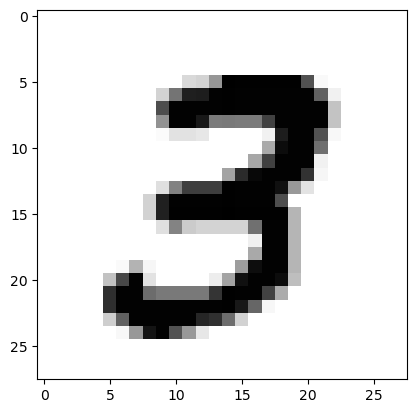

In [23]:
# Display the image
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
plt.imshow(sample_img, cmap="binary")

##### Prepare the Data

The example dataframe here shows the images in their flattened form, in a structure that we're used to. You can start from here, or utilize the Xp/yp variables that were downloaded originally above. The original versions may be quicker to work with, depending on what you do. 

<b>Note:</b> this example classifies into 10 classes, one for each digit, rather than just two. The math behind this is a bit different and more complex, but the process is the same in code. As long as you don't do anything out of the ordinary, this process should work just like a normal classification problem - the only difference being the actual predictions. 

In [24]:
images_df = pd.DataFrame(Xp)
images_df["target"] = yp
images_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


#### Feature Selection and Modelling

Now, we can create some models and do some feature selection along the way. I'm going to wager that the pixels around the edges are less important than the ones in the middle, so we can probably remove some of them. We can pop back up and look at several digits to confirm that the pixels around the edges are mostly unchanging, the values tend to be 0 in nearly all the time. 

Approximately what percentage of the pixels do we need to keep the model accuracy relatively constant. 

In [25]:
#Feature selection 1 - e.g. variance thresh

In [26]:
#Feature selection 2 - e.g. rfecv
#May need to use a subset to keep size manageable. 

In [27]:
#Plot Results

### Example Results

The exact details will vary a bit, but we can see our accuracy flattening out at some point. We could likely filter out ~250 pixels or so from the data and get similar levels of accuracy while using less of the data as inputs to the model. These removed features are likely the outer edges of each image, that are pretty much always white; those don't add any predictive value because they don't vary from image to image. 

Making models on all 70000 images took a while last time with linear regression, so making a change like this will probably save some noticeable processing time. On bigger datasets, with more pixels, and more color, these types of changes can start to add up. When dealing with data that is even larger, this compounds - our images are 784 pixels of greyscale, an iPhone 14 has a camera that takes color images that are 48 million pixels. 

![Feature Selection](../images/feat_sel_pix.png "Feature Selection" )


## Gradient Descent in Linear Regression

We saw, when lookng at logistic regression, a look at how we can create a model that isn't able to be calculated directly, using a cost and gradient descent. The approach is transferable to other problems, such as linear regression. In practice, many/most linear regression models are not calculated directly from the values, they are calculated using gradient descent, just as a logistic regression would be. 

In sklearn, there are several models that we can use that are based on linear regression, but are calculated using gradient descent. These models are generally more flexible and can be used in more situations than the direct calculation models.

### Regularization

When looking at trees we saw pruning - a way to stop the tree from growing too large and overfitting. This pruning was a type of regularization, or applying a penalty to growth. Linear and logistic regression models can also utilize regularization to prevent overfitting. In linear models, regularization is done by applying a penalty to the cost function that is being minimized during training.

There are two types of regularization that are commonly used in linear models:
<ul>
<li>L1 regularization - Lasso regression. Applies a penalty based on the absolute value of the coefficients. This can drive some coefficients to 0, effectively removing them from the model. Slower to calculate. </li>
<li>L2 regularization - Ridge regression. Applies a penalty based on the square of the coefficients. This can drive some coefficients to very small values, but rarely 0. Quicker to calculate. </li>
</ul>

In each case, the change to the process involves an adjustment to the cost function, which is normally just Mean Squared Error. Rather than gradient descent working to minimize the cost function, it now works to minimize the cost function plus the penalty. The penalty is larger when the coefficients are larger, so the model is encouraged to have smaller coefficients. Any increase to a coefficient (i.e. more fitting) needs to overcome the penalty to the cost that will be caused by the growth. The usage of regularization is the same as why we'd use it in a tree, we can adjust a hyperparameter to control the amount of regularization, and this can help us to prevent overfitting. In most cases, a grid search type of test is needed to find an optimal value, but some regularization is very common in many cases, and is sometimes the default in models.

In [28]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2, random_state=42)

#### L1 - Lasso Regression

The first type of regularization we'll look at is L1, or Lasso regression. Lasso regression has the benefit that it will often drive some coefficients to 0, effectively removing them from the model. This can be useful in feature selection, as the features that are not useful will be selected out as the model trains. As well, this can be borrowed by the feature selection tools above, as a way to remove features from the data for use in other models. 

In [29]:
l1_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lasso', Lasso())
])

l1_pipe.fit(Xp_train, yp_train)
l1_preds = l1_pipe.predict(Xp_test)
print("L1 Test Score:", r2_score(yp_test, l1_preds))


TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [ ]:
l1_coef = l1_pipe.named_steps['lasso'].coef_
sns.histplot(l1_coef, bins=50)

#### L2 - Ridge Regression

The second type of regularization we'll look at is L2, or Ridge regression.

Ridge regression is generally faster to calculate than Lasso regression and is extremely common. For more elaborate model types that are built from linear models, such as neural networks, L2 regularization is the most common type of regularization.

In [ ]:
l2_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ridge', Ridge())
])

l2_pipe.fit(Xp_train, yp_train)
l2_preds = l2_pipe.predict(Xp_test)
print("L2 Test Score:", r2_score(yp_test, l2_preds))

#### Elastic Net

Elastic Net is a combination of L1 and L2 regularization, where we calculate both and weight them proportionally based on a hyperparameter setting. The costs and benefits are exactly a combination of the two methods, with the added penalty that both must be calculated here. Elastic Net is less common than the other two types of regularization in practice. 